                               Exact Match Count  Exact Match Accuracy  \
CodeGen-350M-Mono                           57.0              0.033159   
CodeGen-350M-Multi                           0.0              0.000000   
TufanoT5                                   167.0              0.097150   
CodeGen-350M-Mono (no space)               443.0              0.257708   
CodeGen-350M-Multi (no space)                0.0              0.000000   
TufanoT5 (no space)                        167.0              0.097150   

                               Avg BLEU  
CodeGen-350M-Mono              0.520957  
CodeGen-350M-Multi             0.000425  
TufanoT5                       0.761089  
CodeGen-350M-Mono (no space)   0.045828  
CodeGen-350M-Multi (no space)  0.000000  
TufanoT5 (no space)            0.017276  


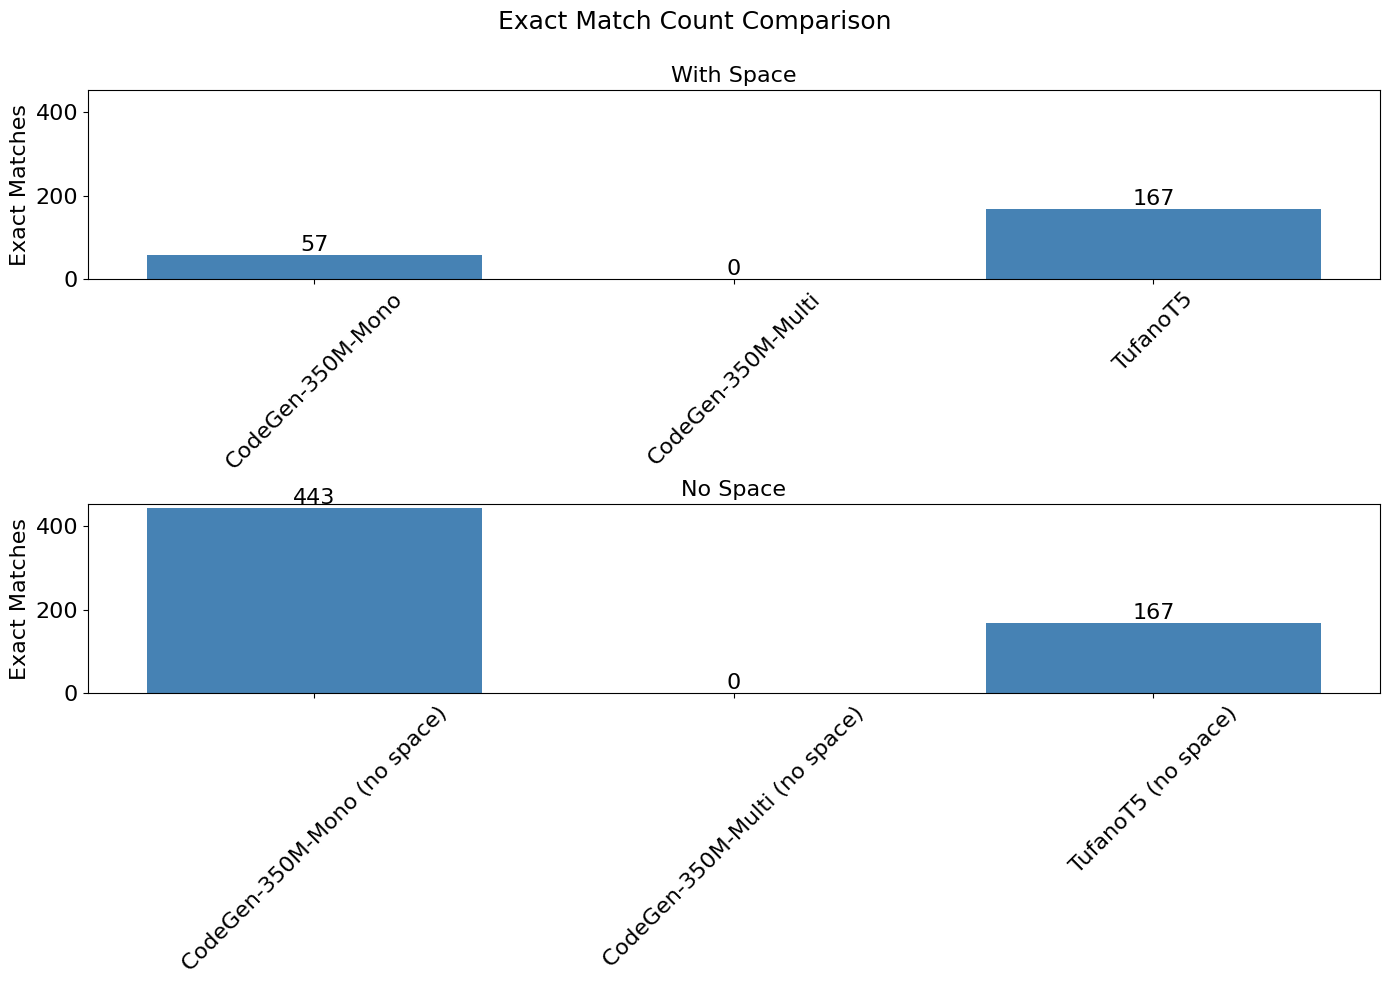

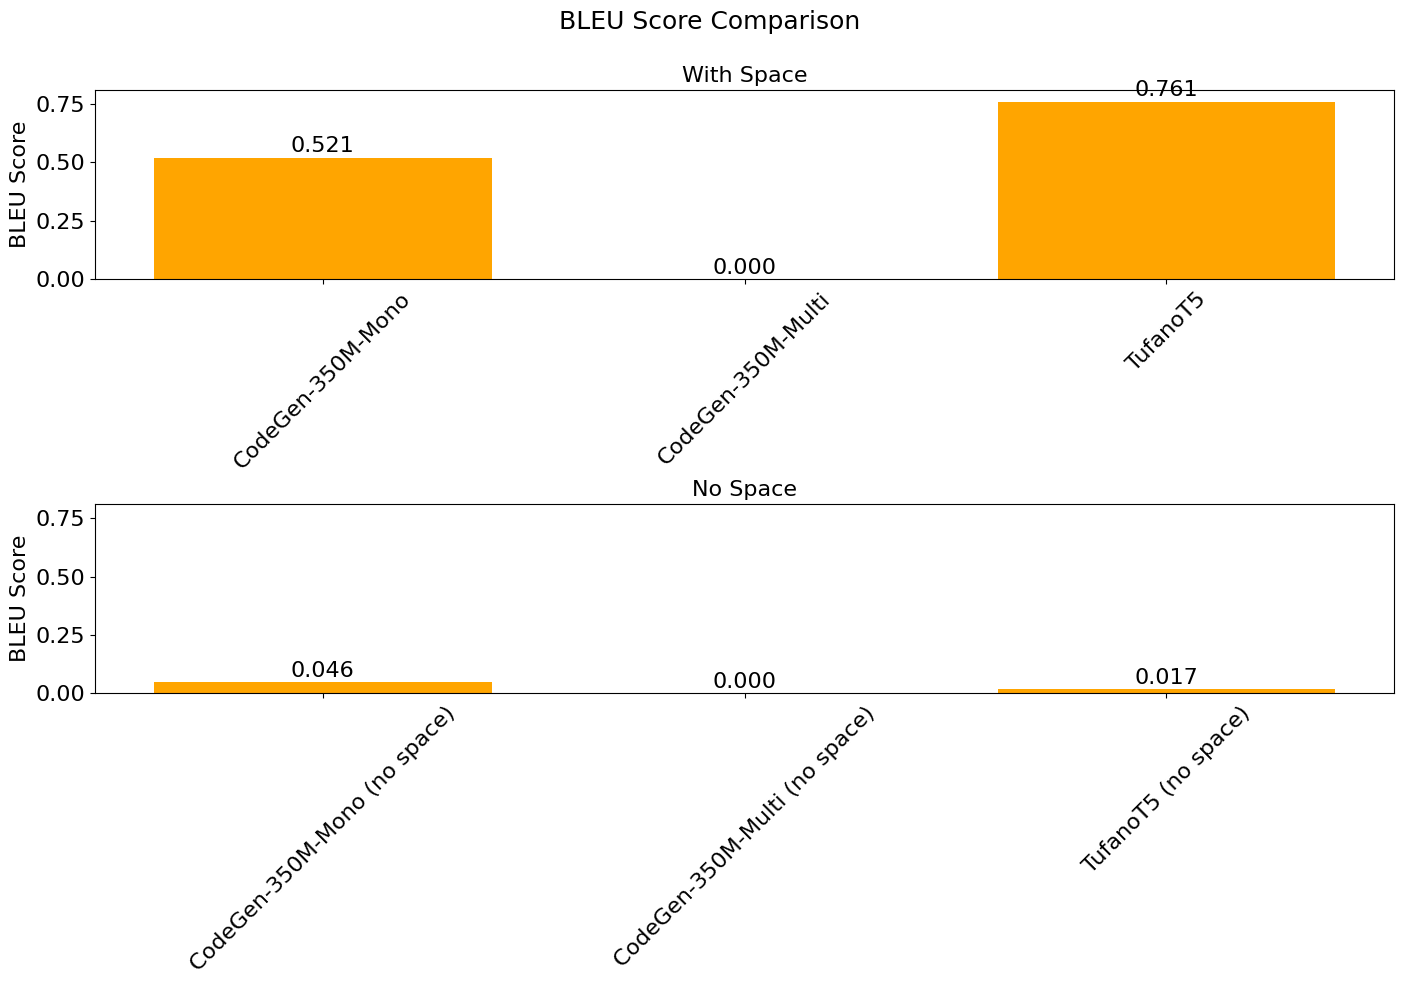

In [17]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Paths to prediction and target files
base_path = Path(".")  # Current directory
files = {
    "CodeGen-350M-Mono": base_path / "final_predictions_350m_mono_ft_comcodetcode.txt",
    "CodeGen-350M-Multi": base_path / "final_predictions_350m_multi_ft_comcodetcode.txt",
    "TufanoT5": base_path / "predictions_tufano_comcodetcode.txt",
    "Target": base_path / "tgt-comcodetcode.txt",
}

# Load text lines from file
def read_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f]

# Load data
mono = read_lines(files["CodeGen-350M-Mono"])
multi = read_lines(files["CodeGen-350M-Multi"])
tufano = read_lines(files["TufanoT5"])
target = read_lines(files["Target"])

assert len(mono) == len(multi) == len(tufano) == len(target), "Mismatch in file lengths"

# Metric computation
def compute_metrics(preds, refs):
    total = len(refs)
    exact_matches = sum(p == r for p, r in zip(preds, refs))
    accuracy = exact_matches / total
    bleu_scores = [
        sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1)
        for pred, ref in zip(preds, refs)
    ]
    avg_bleu = sum(bleu_scores) / total
    return {
        "Exact Match Count": exact_matches,
        "Exact Match Accuracy": accuracy,
        "Avg BLEU": avg_bleu
    }

# Compute all results
results = {
    "CodeGen-350M-Mono": compute_metrics(mono, target),
    "CodeGen-350M-Multi": compute_metrics(multi, target),
    "TufanoT5": compute_metrics(tufano, target),
    "CodeGen-350M-Mono (no space)": compute_metrics([p.replace(" ", "") for p in mono], [r.replace(" ", "") for r in target]),
    "CodeGen-350M-Multi (no space)": compute_metrics([p.replace(" ", "") for p in multi], [r.replace(" ", "") for r in target]),
    "TufanoT5 (no space)": compute_metrics([p.replace(" ", "") for p in tufano], [r.replace(" ", "") for r in target]),
}

# Save as DataFrame
df = pd.DataFrame(results).T
print(df)

# Plotting
labels = df.index.tolist()
match_counts = df["Exact Match Count"].tolist()
bleu_scores = (df["Avg BLEU"] * 1000).tolist()  # scale for visibility

with_space_labels = [label for label in labels if "no space" not in label]
no_space_labels = [label for label in labels if "no space" in label]

# Font sizes
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 16

# --- Plot 1: Exact Match Count ---
fig1, axs1 = plt.subplots(2, 1, figsize=(14, 10))
fig1.suptitle("Exact Match Count Comparison", fontsize=title_fontsize)

max_match = max([results[l]["Exact Match Count"] for l in labels])

# With Space
with_counts = [results[l]["Exact Match Count"] for l in with_space_labels]
bars0 = axs1[0].bar(with_space_labels, with_counts, color='steelblue')
axs1[0].set_title("With Space", fontsize=label_fontsize)
axs1[0].set_ylabel("Exact Matches", fontsize=label_fontsize)
axs1[0].set_ylim(0, max_match + 10)
axs1[0].tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
axs1[0].tick_params(axis='y', labelsize=tick_fontsize)

for bar in bars0:
    height = bar.get_height()
    axs1[0].text(bar.get_x() + bar.get_width()/2., height + 1, f'{int(height)}',
                 ha='center', va='bottom', fontsize=label_fontsize)

# No Space
no_counts = [results[l]["Exact Match Count"] for l in no_space_labels]
bars1 = axs1[1].bar(no_space_labels, no_counts, color='steelblue')
axs1[1].set_title("No Space", fontsize=label_fontsize)
axs1[1].set_ylabel("Exact Matches", fontsize=label_fontsize)
axs1[1].set_ylim(0, max_match + 10)
axs1[1].tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
axs1[1].tick_params(axis='y', labelsize=tick_fontsize)

for bar in bars1:
    height = bar.get_height()
    axs1[1].text(bar.get_x() + bar.get_width()/2., height + 1, f'{int(height)}',
                 ha='center', va='bottom', fontsize=label_fontsize)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


# --- Plot 2: BLEU Score ---
fig2, axs2 = plt.subplots(2, 1, figsize=(14, 10))
fig2.suptitle("BLEU Score Comparison", fontsize=title_fontsize)

max_bleu = max([results[l]["Avg BLEU"] for l in labels])

# With Space
with_bleu = [results[l]["Avg BLEU"] for l in with_space_labels]
bars2 = axs2[0].bar(with_space_labels, with_bleu, color='orange')
axs2[0].set_title("With Space", fontsize=label_fontsize)
axs2[0].set_ylabel("BLEU Score", fontsize=label_fontsize)
axs2[0].set_ylim(0, max_bleu + 0.05)
axs2[0].tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
axs2[0].tick_params(axis='y', labelsize=tick_fontsize)

for bar in bars2:
    height = bar.get_height()
    axs2[0].text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=label_fontsize)

# No Space
no_bleu = [results[l]["Avg BLEU"] for l in no_space_labels]
bars3 = axs2[1].bar(no_space_labels, no_bleu, color='orange')
axs2[1].set_title("No Space", fontsize=label_fontsize)
axs2[1].set_ylabel("BLEU Score", fontsize=label_fontsize)
axs2[1].set_ylim(0, max_bleu + 0.05)
axs2[1].tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
axs2[1].tick_params(axis='y', labelsize=tick_fontsize)

for bar in bars3:
    height = bar.get_height()
    axs2[1].text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=label_fontsize)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



                               Exact Match Count  Exact Match Accuracy  \
CodeGen-350M-Mono                           19.0              0.011053   
CodeGen-350M-Multi                          20.0              0.011635   
TufanoT5                                    33.0              0.019197   
CodeGen-350M-Mono (no space)               171.0              0.099476   
CodeGen-350M-Multi (no space)              189.0              0.109948   
TufanoT5 (no space)                         33.0              0.019197   

                               Avg BLEU  
CodeGen-350M-Mono              0.473591  
CodeGen-350M-Multi             0.479891  
TufanoT5                       0.683169  
CodeGen-350M-Mono (no space)   0.017690  
CodeGen-350M-Multi (no space)  0.019552  
TufanoT5 (no space)            0.003414  


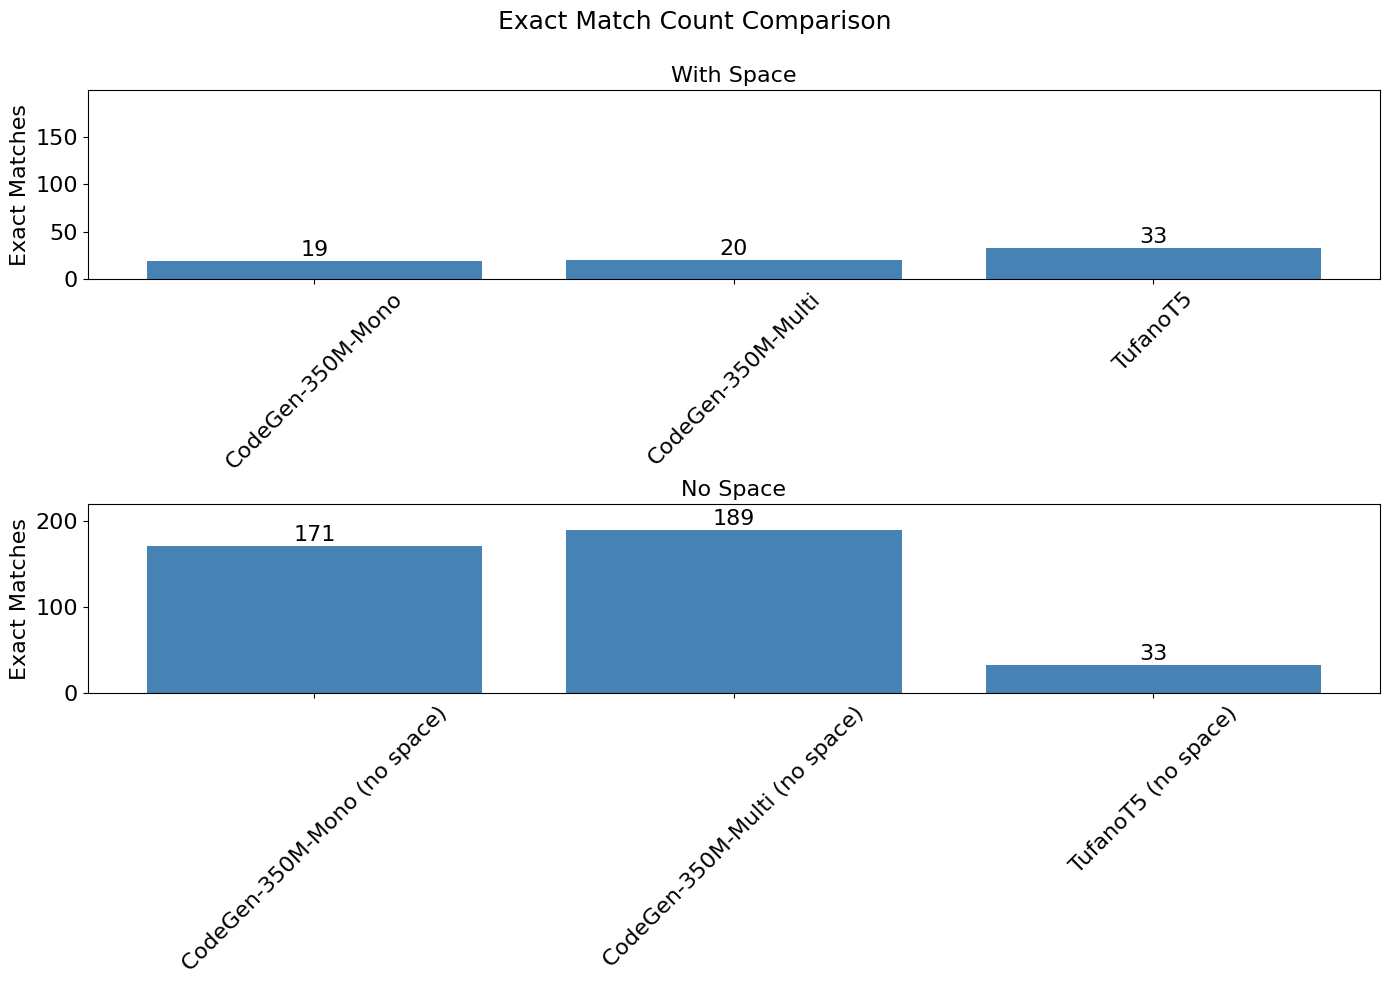

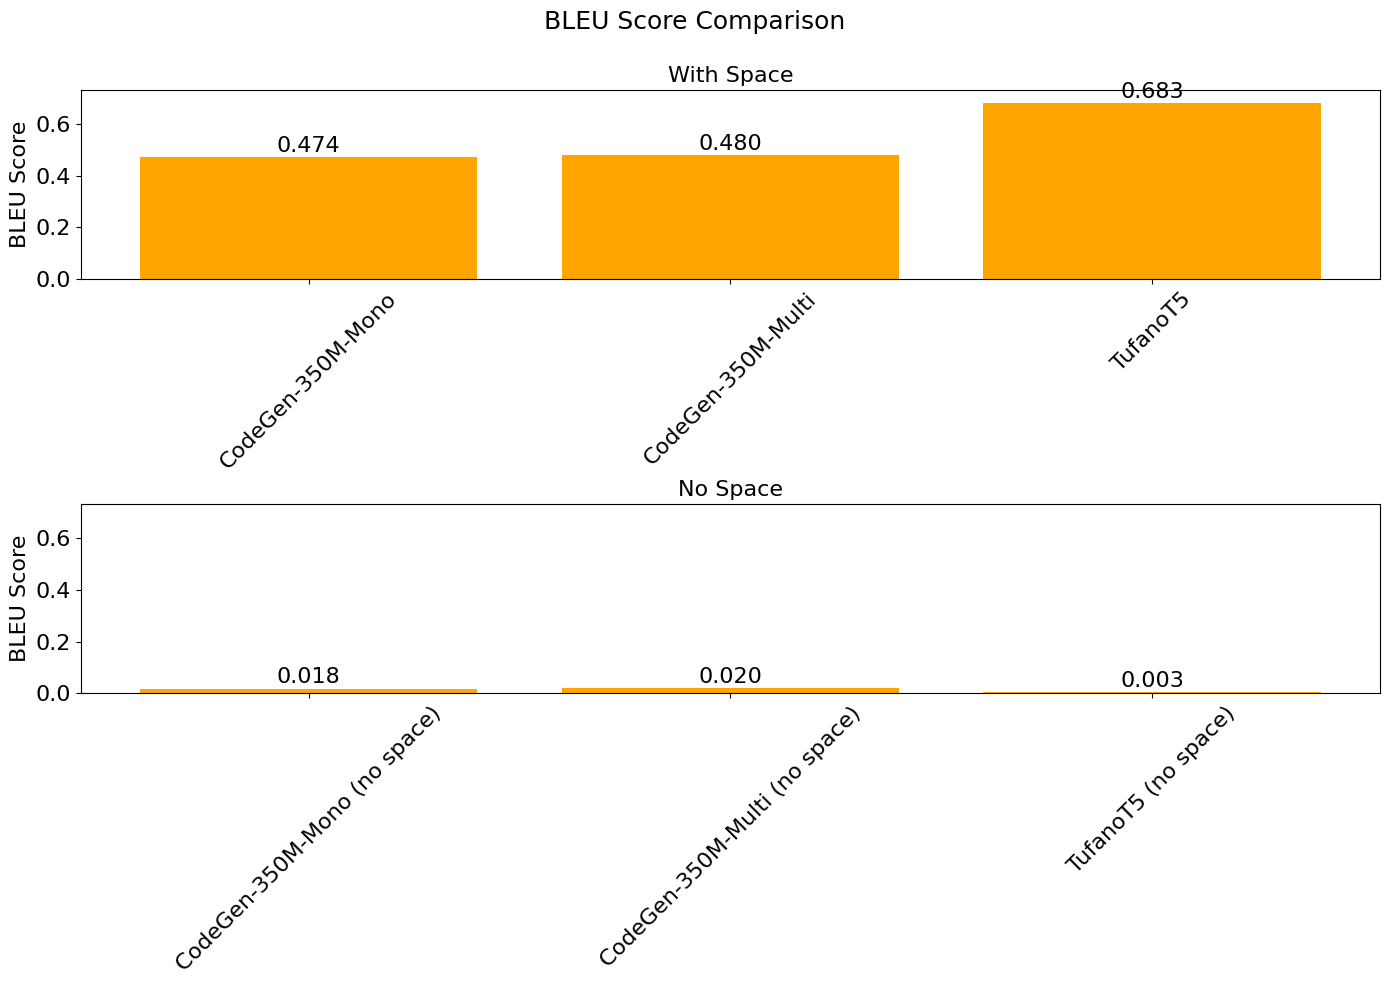

In [18]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Paths to prediction and target files
base_path = Path(".")  # Current directory
files = {
    "CodeGen-350M-Mono": base_path / "final_predictions_350m_mono_ft_ctc.txt",
    "CodeGen-350M-Multi": base_path / "final_predictions_350m_multi_ft_ctc.txt",
    "TufanoT5": base_path / "predictions_tufano_ctc.txt",
    "Target": base_path / "tgt-ctc.txt",
}

# Load text lines from file
def read_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f]

# Load data
mono = read_lines(files["CodeGen-350M-Mono"])
multi = read_lines(files["CodeGen-350M-Multi"])
tufano = read_lines(files["TufanoT5"])
target = read_lines(files["Target"])

assert len(mono) == len(multi) == len(tufano) == len(target), "Mismatch in file lengths"

# Metric computation
def compute_metrics(preds, refs):
    total = len(refs)
    exact_matches = sum(p == r for p, r in zip(preds, refs))
    accuracy = exact_matches / total
    bleu_scores = [
        sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1)
        for pred, ref in zip(preds, refs)
    ]
    avg_bleu = sum(bleu_scores) / total
    return {
        "Exact Match Count": exact_matches,
        "Exact Match Accuracy": accuracy,
        "Avg BLEU": avg_bleu
    }

# Compute all results
results = {
    "CodeGen-350M-Mono": compute_metrics(mono, target),
    "CodeGen-350M-Multi": compute_metrics(multi, target),
    "TufanoT5": compute_metrics(tufano, target),
    "CodeGen-350M-Mono (no space)": compute_metrics([p.replace(" ", "") for p in mono], [r.replace(" ", "") for r in target]),
    "CodeGen-350M-Multi (no space)": compute_metrics([p.replace(" ", "") for p in multi], [r.replace(" ", "") for r in target]),
    "TufanoT5 (no space)": compute_metrics([p.replace(" ", "") for p in tufano], [r.replace(" ", "") for r in target]),
}

# Save as DataFrame
df = pd.DataFrame(results).T
print(df)

# Plotting
labels = df.index.tolist()
match_counts = df["Exact Match Count"].tolist()
bleu_scores = (df["Avg BLEU"] * 1000).tolist()  # scale for visibility

with_space_labels = [label for label in labels if "no space" not in label]
no_space_labels = [label for label in labels if "no space" in label]

# Font sizes
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 16

# --- Plot 1: Exact Match Count ---
fig1, axs1 = plt.subplots(2, 1, figsize=(14, 10))
fig1.suptitle("Exact Match Count Comparison", fontsize=title_fontsize)

max_match = max([results[l]["Exact Match Count"] for l in labels])

# With Space
with_counts = [results[l]["Exact Match Count"] for l in with_space_labels]
bars0 = axs1[0].bar(with_space_labels, with_counts, color='steelblue')
axs1[0].set_title("With Space", fontsize=label_fontsize)
axs1[0].set_ylabel("Exact Matches", fontsize=label_fontsize)
axs1[0].set_ylim(0, max_match + 10)
axs1[0].tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
axs1[0].tick_params(axis='y', labelsize=tick_fontsize)

for bar in bars0:
    height = bar.get_height()
    axs1[0].text(bar.get_x() + bar.get_width()/2., height + 1, f'{int(height)}',
                 ha='center', va='bottom', fontsize=label_fontsize)

# No Space
no_counts = [results[l]["Exact Match Count"] for l in no_space_labels]
bars1 = axs1[1].bar(no_space_labels, no_counts, color='steelblue')
axs1[1].set_title("No Space", fontsize=label_fontsize)
axs1[1].set_ylabel("Exact Matches", fontsize=label_fontsize)
axs1[1].set_ylim(0, max_match + 30)
axs1[1].tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
axs1[1].tick_params(axis='y', labelsize=tick_fontsize)

for bar in bars1:
    height = bar.get_height()
    axs1[1].text(bar.get_x() + bar.get_width()/2., height + 1, f'{int(height)}',
                 ha='center', va='bottom', fontsize=label_fontsize)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# --- Plot 2: BLEU Score ---
fig2, axs2 = plt.subplots(2, 1, figsize=(14, 10))
fig2.suptitle("BLEU Score Comparison", fontsize=title_fontsize)

max_bleu = max([results[l]["Avg BLEU"] for l in labels])

# With Space
with_bleu = [results[l]["Avg BLEU"] for l in with_space_labels]
bars2 = axs2[0].bar(with_space_labels, with_bleu, color='orange')
axs2[0].set_title("With Space", fontsize=label_fontsize)
axs2[0].set_ylabel("BLEU Score", fontsize=label_fontsize)
axs2[0].set_ylim(0, max_bleu + 0.05)
axs2[0].tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
axs2[0].tick_params(axis='y', labelsize=tick_fontsize)

for bar in bars2:
    height = bar.get_height()
    axs2[0].text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=label_fontsize)

# No Space
no_bleu = [results[l]["Avg BLEU"] for l in no_space_labels]
bars3 = axs2[1].bar(no_space_labels, no_bleu, color='orange')
axs2[1].set_title("No Space", fontsize=label_fontsize)
axs2[1].set_ylabel("BLEU Score", fontsize=label_fontsize)
axs2[1].set_ylim(0, max_bleu + 0.05)
axs2[1].tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
axs2[1].tick_params(axis='y', labelsize=tick_fontsize)

for bar in bars3:
    height = bar.get_height()
    axs2[1].text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=label_fontsize)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

